## Food Image Classification


This notebook utilizes the Food Image Classification dataset from Kaggle (https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset/data) to develop and evaluate a machine learning model for classifying food images into their respective categories. The analysis is performed using PyTorch, focusing on model selection, optimization, and rigorous performance evaluation. Key objectives include:

1. Image Classification: Implement and refine a machine learning model capable of accurately classifying diverse food images.

2. Model Optimization: Employ PyTorch to explore various architectures, optimization strategies, and hyperparameter tuning to enhance model accuracy and generalizability.

The final goal is to achieve a model that demonstrates high accuracy and robustness, potentially supporting applications in automated nutritional analysis and food discovery platforms.

## Import libraries

In [1]:
import matplotlib.pyplot as plt # for data viz
import numpy as np # for data manipulation
import PIL # to read images
from PIL import Image

# for the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold

# to get to the files we need
import os
from os import listdir
 

ModuleNotFoundError: No module named 'tensorflow'

## Read & clean the data

In [31]:
data_dir = 'Food_Classification_dataset' # Initialize the data directory

In [32]:
def list_files(dir): # This is a function that outputs a list of files for a folder, even if it has subfolders
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [33]:
img_height = 224
img_width = 224

In [34]:
standard_size = (img_height, img_width) # This is the size we want all images to be, as some are of different sizes
file_list = list_files(data_dir) # The list of file names
print("Length:", len(file_list))
for i, file_path in enumerate(file_list): # for each file, resize the image and convert to .jpg if needed
    if i % 1000 == 0:
        print(i)
    with Image.open(file_path) as img: # convert all images to .jpg
        img.convert('RGB')

        if os.path.splitext(file_path)[1] != '.jpg':
            
            output_filename = os.path.splitext(file_path)[0] + '.jpg'
            output_path = file_path
            os.remove(file_path) # delete the original image

        img_resized = img.resize(standard_size, PIL.Image.LANCZOS) # resize the image
        img_resized.save(file_path) 


Length: 23870
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


## Initialize/prep the model

In [35]:
# Set the batch size
batch_size = 32


In [36]:
# Create the dataset from the directory
full_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,

  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 23870 files belonging to 34 classes.


In [37]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

full_ds = full_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


# Standardize the data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = full_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [38]:
# Set 90% of values to be training values
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23870 files belonging to 34 classes.
Using 21483 files for training.


In [39]:
# Set 10% of values to be validation values
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23870 files belonging to 34 classes.
Using 2387 files for validation.


In [40]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE



In [41]:
# Standardize the data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.98823535


## Create the model 

In [43]:
# Change the data up a little (rotation and zoom) to prevent overfitting
data_augmentation = keras.Sequential([ 
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.7),
  layers.RandomZoom(0.4)
])

In [44]:
# Here, we use a pre-built model -- the MobileNetV2 one. Initially, we don't change the base model, and we have three dense layers with high filter sizes to increase the complexity of the model.

base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
num_classes = len(train_ds.class_names) # set the number of classes
model = Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.BatchNormalization(),

    
  layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.BatchNormalization(),
  layers.Dropout(0.3), 

    
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.BatchNormalization(),
  layers.Dropout(0.3), 
    

  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.BatchNormalization(),
  layers.Dropout(0.3),  
  layers.Dense(num_classes, activation='softmax')
])




In [45]:
def lr_schedule(epoch, lr): #Define our learning rate
    # Start with 1e-3 and decrease the learning rate by an order of magnitude each epoch,
    # down to a minimum of 1e-10.
    if epoch < 10:
        return 1e-3 * (10 ** (-epoch))
    else:
        return 1e-10

## Compile the model

In [46]:

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [47]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
epochs= 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_scheduler_callback]
)

Epoch 1/10
672/672 [==============================] - 393s 563ms/step - loss: 3.2237 - accuracy: 0.4570 - val_loss: 7.4823 - val_accuracy: 0.1052 - lr: 0.0010
Epoch 2/10
672/672 [==============================] - 359s 535ms/step - loss: 1.9817 - accuracy: 0.7194 - val_loss: 2.2827 - val_accuracy: 0.6380 - lr: 1.0000e-04
Epoch 3/10
672/672 [==============================] - 377s 561ms/step - loss: 1.7262 - accuracy: 0.7834 - val_loss: 1.6861 - val_accuracy: 0.7863 - lr: 1.0000e-05
Epoch 4/10
672/672 [==============================] - 354s 526ms/step - loss: 1.6920 - accuracy: 0.7937 - val_loss: 1.5981 - val_accuracy: 0.8182 - lr: 1.0000e-06
Epoch 5/10
672/672 [==============================] - 352s 523ms/step - loss: 1.6976 - accuracy: 0.7900 - val_loss: 1.5800 - val_accuracy: 0.8178 - lr: 1.0000e-07
Epoch 6/10
672/672 [==============================] - 380s 565ms/step - loss: 1.6973 - accuracy: 0.7895 - val_loss: 1.5779 - val_accuracy: 0.8199 - lr: 1.0000e-08
Epoch 7/10
672/672 [======

## Visualize model results

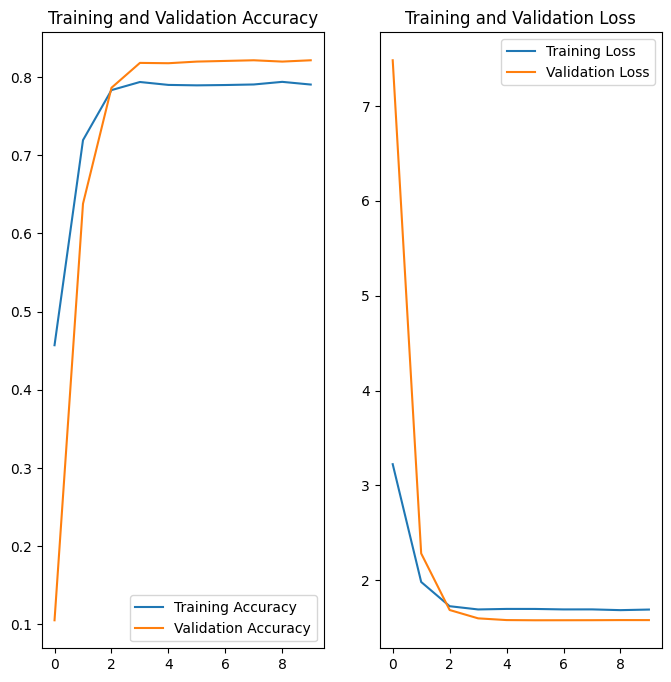

In [48]:
# For the original training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()